In [1]:
from IPython.display import display, HTML

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h1 style="color:red;">DI-725 : Transformers and Attention-Based Deep Networks</h1>
  <h2 style="color:red;">Final Project : Phase - 2</h2>
  <br><br>
  <h4 style="color:red;">Turgay Yıldız</h4>
  <br>
  <h4 style="color:red;">Graduate School of Informatics, Middle East Technical University (METU)</h4>
</div>

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Fetch big_vision code and install dependencies</h3>
</div>

In [2]:
import os
import sys
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==

In [3]:
# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [4]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [5]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.5 MB/s eta 0:00:00


In [6]:
import os
from google.colab import userdata

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model and Pre-trained weights : </h3>
</div>

In [7]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["..."] =    '...'
os.environ["..."]      =    '...' 

In [8]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [9]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

In [10]:
# Use these for PaliGemma-2 3B 224px²
#LLM_VARIANT   = "gemma2_2b"
#MODEL_PATH    = "./paligemma2-3b-pt-224.b16.npz"
#KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

In [11]:
# Use these for PaliGemma 1:
LLM_VARIANT   = "gemma_2b"
MODEL_PATH    = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224" 

In [12]:
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [13]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !wget https://storage.googleapis.com/big_vision/paligemma_tokenizer.model -O {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")


--2025-05-09 02:55:44--  https://storage.googleapis.com/big_vision/paligemma_tokenizer.model
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.199.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4264023 (4.1M) [application/octet-stream]
Saving to: ‘./paligemma_tokenizer.model’

./paligemma_tokeniz 100%[===================>]   4.07M  3.76MB/s    in 1.1s    

2025-05-09 02:55:46 (3.76 MB/s) - ‘./paligemma_tokenizer.model’ saved [4264023/4264023]

Tokenizer path: ./paligemma_tokenizer.model


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Core Library Imports : </h3>
</div>

In [14]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding


2025-05-09 02:55:51.942469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746759352.141179      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746759352.195448      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Reserve GPU/TPU for JAX </h3>
</div>

In [15]:
# Don't let TF use the GPU or TPUs
# Disables TensorFlow’s access to GPUs/TPUs so JAX can fully utilize them without resource contention.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Construct model and load params into RAM </h3>

 <h5 style="color:red;"> model_config: hyperparameters for both the vision encoder and text decoder.
<br>
                          Instantiate the combined Vision+LLM model.
<br>
                          Load pretrained weights into a parameter tree.
<br>
                          Build a decode function for efficient batched generation.
                          </h5>


</div>

In [16]:
# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
#model_config = ml_collections.FrozenConfigDict({
#    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
#    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
#})
#--------------------------------------------------------------------------------------------------------#
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

In [17]:
model     = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH) 

In [18]:
# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Soft Prompt Embeddings: </h3>
</div>

In [19]:
model_config.llm

final_logits_softcap: 0.0
variant: gemma_2b
vocab_size: 257152

In [58]:
# After `params = paligemma.load(...)` and before sharding:
PROMPT_LEN    =   10
hidden_size   =   2048 

In [59]:
# Initialize soft prompts (e.g. normal random)
soft_prompt = jax.random.normal(
    jax.random.PRNGKey(0), (PROMPT_LEN, hidden_size)
).astype(jnp.float32)

# Add it to your param PyTree so it's updated by JAX:
params = {"soft_prompt": soft_prompt, **params} 


In [21]:
tokenizer.eos_id()

1

In [60]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()) 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Prepare for Partial Fine-Tuning :  </h3>

  <h5 style="color:red;">  Defines a rule that only attention layers in the LLM ("llm/layers/attn/…") are trainable; everything else stays frozen.
<br>
Creates a parallel "mask" PyTree of booleans marking which sub-trees to update.
</h5>
</div> 

In [61]:
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("soft_prompt"):       return True 
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
      
  raise ValueError(f"Unexpected param name {name}")
    
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sharding & Casting Parameters :  </h3>

  <h5 style="color:red;">  Sharding: split tensors across devices (if you had >1 GPU).
<br>
                        maybe_cast_to_f32: keep the frozen weights in fp16 to save memory; cast the few trainable ones to fp32 so their gradients remain stable.
<br>
                        The loop unpacks the parameter tree, reshares & casts each leaf, and reassembles it.
</h5>
</div>


In [62]:
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

In [63]:
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

In [64]:
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

In [65]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [66]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [67]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef  = jax.tree.flatten(params)
sharding_leaves  = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)

for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

In [68]:
# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


In [69]:
print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define preprocess functions to create inputs to the model :  </h3>
</div>

In [70]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
def preprocess_tokens(suffix: str | None, seqlen: int = None):
    """
    Tokenize only the suffix (caption) and build masks,
    leaving room for PROMPT_LEN soft‐prompt embeddings.

    Returns:
      tokens      : np.int32 array of length seqlen (or PROMPT_LEN if no suffix)
      mask_ar     : np.int32 array, 0=full attention (for prefix), 1=causal (for suffix)
      mask_loss   : np.int32 array, 0=no loss on prefix, 1=loss on suffix
      mask_input  : np.int32 array, 1=real token, 0=padding
    """
    # 1) Tokenize suffix if given
    if suffix is not None:
        # separator token
        sep_ids = tokenizer.encode("\n", add_bos=False, add_eos=False)
        suf_ids = tokenizer.encode(suffix, add_bos=False, add_eos=True)
        
        tokens_suf    = sep_ids + suf_ids
        mask_ar_suf   = [1] * len(tokens_suf)
        mask_loss_suf = [1] * len(tokens_suf)
    else:
        tokens_suf    = []
        mask_ar_suf   = []
        mask_loss_suf = []

    # 2) Build the combined sequence
    #    Prefix (soft prompts) occupy positions [0..PROMPT_LEN-1], so we
    #    start our discrete IDs at index PROMPT_LEN.
    tokens     = [0] * PROMPT_LEN  + tokens_suf
    mask_ar    = [0] * PROMPT_LEN  + mask_ar_suf
    mask_loss  = [0] * PROMPT_LEN  + mask_loss_suf
    mask_input = [0] * PROMPT_LEN  + [1] * len(tokens_suf)

    # 3) Pad/truncate to seqlen if requested
    if seqlen is not None:
        length = len(tokens)
        if length < seqlen:
            pad_len = seqlen - length
            tokens     += [0] * pad_len
            mask_ar    += [0] * pad_len
            mask_loss  += [0] * pad_len
            mask_input += [0] * pad_len
        else:
            tokens     = tokens[:seqlen]
            mask_ar    = mask_ar[:seqlen]
            mask_loss  = mask_loss[:seqlen]
            mask_input = mask_input[:seqlen]

    # 4) Return as arrays
    return (
        np.array(tokens,     dtype=np.int32),
        np.array(mask_ar,    dtype=np.int32),
        np.array(mask_loss,  dtype=np.int32),
        np.array(mask_input, dtype=np.int32),
    )
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [75]:
out   =   preprocess_tokens("hello world", 128) 

In [76]:
out[0].shape, out[1].shape, out[2].shape, out[3].shape

((128,), (128,), (128,), (128,))

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Import Data  :  </h3>
</div>

In [77]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
# List all datasets under /kaggle/input
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    print(f"Directory: {dirname}")
#    for filename in filenames:
#        print(f"  File: {filename}")


In [ ]:
#weights = np.load('/kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.npz')
#print(weights.files[:5])  # print first 5 weight names


In [34]:
captions_df = pd.read_csv('/kaggle/input/rsics-dataset/captions.csv')
print(captions_df.head()) 

  source split           image  \
0   NWPU  test  NWPU_31430.jpg   
1   NWPU  test  NWPU_31431.jpg   
2   NWPU  test  NWPU_31432.jpg   
3   NWPU  test  NWPU_31433.jpg   
4   NWPU  test  NWPU_31434.jpg   

                                           caption_1  \
0   A gray plane on the runway and the lawn beside .   
1  Three small planes parked in a line on the air...   
2  A plane parked in a line on the airport with s...   
3  A small plane and a big plane parked next to b...   
4       Two planes parked next to boarding bridges .   

                                           caption_2  \
0        A grey plane is on the runway by the lawn .   
1  There are four aircraft on the open ground, Th...   
2  A white plane was parked on the instruction li...   
3  A white plane and a gray plane parked at the b...   
4  Two aircraft were parked at the departure gates .   

                                           caption_3  \
0  There is an airplane on the runway with a larg...   
1  There 

In [35]:

IMAGE_ROOT = "/kaggle/input/rsics-dataset/resized" 
BATCH_SIZE = 32
IMG_SIZE   = (224, 224) 

In [36]:
print("All split labels:", captions_df['split'].unique())
print("Counts:\n", captions_df['split'].value_counts())

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [37]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = captions_df[captions_df['split'] == split_name] 

In [38]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions

In [39]:
train_paths, train_caps = df_to_paths_and_captions(splits['train'])
val_paths,   val_caps   = df_to_paths_and_captions(splits['val'])
test_paths,  test_caps  = df_to_paths_and_captions(splits['test']) 

In [40]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE)
         )
    return ds

In [41]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=True) 
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False)

In [42]:
# 8. Quick sanity check
for imgs, caps in test_ds.take(1):
    print("Images batch shape:", imgs.shape)            # (BATCH_SIZE, H, W, 3)
    print("Captions batch shape:", len(caps), "examples")
    print("First example captions:", caps[0])            # a list of 5 strings

Images batch shape: (32, 224, 224, 3)
Captions batch shape: 32 examples
First example captions: tf.Tensor(
[b'A gray plane on the runway and the lawn beside .'
 b'A grey plane is on the runway by the lawn .'
 b'There is an airplane on the runway with a large lawn by the runway .'
 b'A plane is parked on the runway next to the grass .'
 b'There is a plane on the runway beside the grass .'], shape=(5,), dtype=string)


In [44]:
SEQLEN  =  128 

In [78]:
def train_data_iterator():
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                decoded_caps = [c.decode('utf-8') for c in caps]             #  All Captions
                suffix       = decoded_caps[np.random.randint(5)].lower()    #  Randomly pick one  

                # Prepare tokens and masks
                tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens(suffix,  128) 
                
                img_proc = img * 2.0 - 1.0
                yield [{
                    "image": img_proc,
                    "text": np.asarray(tokens, dtype=np.int32),
                    "mask_ar": np.asarray(mask_ar, dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss, dtype=np.int32),
                    "mask_input": np.asarray(mask_in,  dtype=np.int32),  # ← Add this
                }, decoded_caps] 

def validation_data_iterator():
    """Single-pass iterator over validation examples from val_ds."""
    for image_batch, caps_batch in val_ds:
        images_np = image_batch.numpy()
        caps_np   = caps_batch.numpy()

        for img, caps in zip(images_np, caps_np):
            decoded_caps = [c.decode('utf-8') for c in caps]       #  All Captions 

            # Prepare tokens and masks
            tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens(None,  128)    # suffix = None 
            
            img_proc = img * 2. - 1.
            yield [{
                "image": img_proc,
                "text": np.asarray(tokens, dtype=np.int32),
                "mask_input": np.asarray(mask_in, dtype=np.int32),
                "mask_ar": np.asarray(mask_ar, dtype=np.int32), 
            }, decoded_caps]


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Check Iterators :  </h3>
</div>

In [80]:
val_it = validation_data_iterator()
       
for _ in range(1):
    ex   = next(val_it) 

In [81]:
ex[0]["image"].shape,   ex[0]["text"].shape,  ex[0]["mask_input"].shape,   ex[0]["mask_ar"].shape

((224, 224, 3), (128,), (128,), (128,))

In [82]:
ex[1]

['An airport with some staggered runways and buildings on the farmland and some villages beside .',
 'There is almost no vegetation near the airport .',
 'A complex airport with many runways and buildings is surrounded by a brown and green farmland .',
 'There is an airport on the open place in the middle of the field .',
 'The ground of the airfield is marked .']

In [85]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


In [86]:
import html

In [88]:
len(ex[1]) 

5


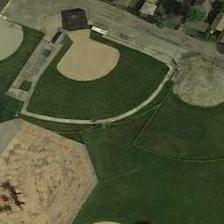
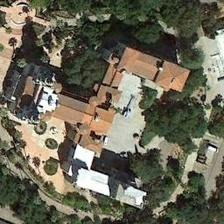
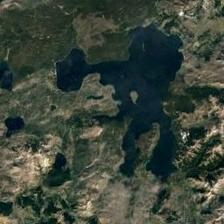
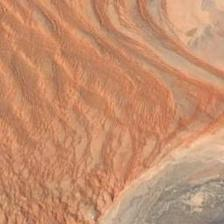

In [89]:
html_out = ""
for idx, example in zip(range(4), train_data_iterator()): 
    img = example[0]["image"] 
    
    html_out += render_example(img, example[1][0]) 
    # optionally a divider between images:
    html_out += "<hr style='width:100%;'>"

display(HTML("<h3>Training examples </h3>" + html_out))


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Training step with simple SGD :  </h3>
</div>

In [91]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Evaluation / Inference Loop :  </h3>
</div>

In [115]:
# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    captions = [] 
    try:
      for _ in range(batch_size):

        example, caps = next(data_iterator) 
        example["_mask"]   = np.array(True)
        example["caption"] = caps
        
        # Keep the caption aside
        caption = example.pop("caption") 
        captions.append(caption)
        
        examples.append(example)


    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response, caption in zip(examples, responses, captions):
        outputs.append((example["image"], response, caption))
   
        if num_examples and len(outputs) >= num_examples:
            return outputs

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Check the predictions :  </h3>
</div>

In [120]:
img, pred, ref = make_predictions(validation_data_iterator(),
                                  num_examples=1,
                                  batch_size=1)[0]


In [121]:
print("PRED:", pred)
print("REF:", ref) 

PRED:  website website
REF: ['the factory has several parking lots one of which is filled with automobiles .', 'the factory has several parking lots one of which is filled with automobiles .', 'an alley separates the industrial which contains grey workshops and a parking lot .', 'several parking lots are settled in this prosperous industrial area .', 'many gray industrial buildings with several parking lots are in a factory .']


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> WANDB :  </h3>
</div>

In [122]:
import wandb

In [127]:
wandb.finish() 

In [ ]:
os.environ["..."]       = "..."

run  =  wandb.init(project="...", entity="...")  

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Train :  </h3>
</div>

In [ ]:
(35614 / 8 )  *  0.01

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


step: 1/4451   lr: 0.00000222   loss: 6.1758
→ Evaluation at step 1
   BLEU:   0.000
   ROUGE1: 0.009, ROUGE2: 0.001, ROUGEL: 0.008
   METEOR: 0.004



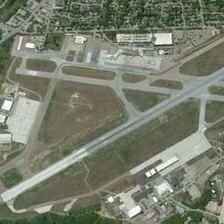
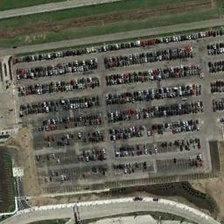
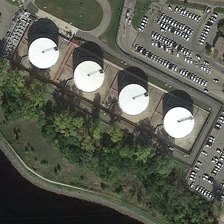
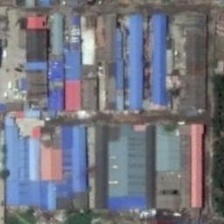

step: 2/4451   lr: 0.00000444   loss: 5.6045
step: 3/4451   lr: 0.00000667   loss: 5.8842
step: 4/4451   lr: 0.00000889   loss: 5.4186
step: 5/4451   lr: 0.00001111   loss: 5.5563
step: 6/4451   lr: 0.00001333   loss: 5.6379
step: 7/4451   lr: 0.00001556   loss: 5.3721
step: 8/4451   lr: 0.00001778   loss: 4.7038
step: 9/4451   lr: 0.00002000   loss: 5.3873
step: 10/4451   lr: 0.00002222   loss: 5.2870
step: 11/4451   lr: 0.00002444   loss: 4.9298
step: 12/4451   lr: 0.00002667   loss: 5.2702
step: 13/4451   lr: 0.00002889   loss: 5.2071
step: 14/4451   lr: 0.00003111   loss: 5.0541
step: 15/4451   lr: 0.00003333   loss: 4.7453
step: 16/4451   lr: 0.00003556   loss: 4.7996
step: 17/4451   lr: 0.00003778   loss: 4.2714
step: 18/4451   lr: 0.00004000   loss: 4.5210
step: 19/4451   lr: 0.00004222   loss: 4.6637
step: 20/4451   lr: 0.00004444   loss: 4.4380
step: 21/4451   lr: 0.00004667   loss: 4.6418
step: 22/4451   lr: 0.00004889   loss: 4.4290
step: 23/4451   lr: 0.00005111   loss: 4.4


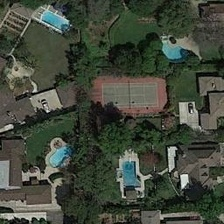
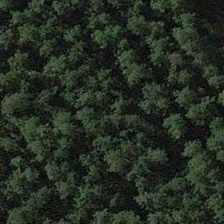
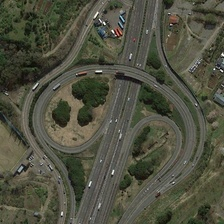
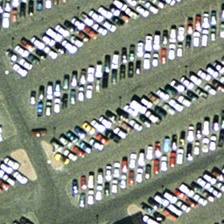

step: 51/4451   lr: 0.00010000   loss: 3.1103
step: 52/4451   lr: 0.00010000   loss: 2.7851
step: 53/4451   lr: 0.00010000   loss: 2.6679
step: 54/4451   lr: 0.00010000   loss: 2.7695
step: 55/4451   lr: 0.00010000   loss: 2.9114
step: 56/4451   lr: 0.00010000   loss: 2.6318
step: 57/4451   lr: 0.00010000   loss: 2.9956
step: 58/4451   lr: 0.00010000   loss: 2.9778
step: 59/4451   lr: 0.00010000   loss: 2.9301
step: 60/4451   lr: 0.00010000   loss: 3.0856
step: 61/4451   lr: 0.00010000   loss: 2.7973
step: 62/4451   lr: 0.00010000   loss: 3.2409
step: 63/4451   lr: 0.00010000   loss: 2.2958
step: 64/4451   lr: 0.00010000   loss: 3.2876


In [ ]:
import io, base64
from PIL import Image
from IPython.display import HTML, display

import wandb
import pickle
import evaluate
import tqdm
#---------------------------------------------------------------------------------------------------------------------------#
# 1) Install & load metrics
#    pip install evaluate
bleu_metric   = evaluate.load("bleu")
rouge_metric  = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
#---------------------------------------------------------------------------------------------------------------------------#
# 2) Hyperparams
BATCH_SIZE     = 8 
TRAIN_EXAMPLES = 35614 
LEARNING_RATE  = 0.0001 

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS  = 50            #max(1, TRAIN_STEPS // 100)   
#---------------------------------------------------------------------------------------------------------------------------#
#run = wandb.init(project="DI_725_Project_Phase_2__2697258", reinit=True, settings=wandb.Settings(init_timeout=500))


run.config.update({
    "model_name"     : "PaliGemma soft-prompt", 
    "batch_size"     : BATCH_SIZE,
    "train_examples" : TRAIN_EXAMPLES,
    "learning_rate"  : LEARNING_RATE,
    "train_steps"    : TRAIN_STEPS,
    "eval_steps"     : EVAL_STEPS,
})
#---------------------------------------------------------------------------------------------------------------------------#
# 3) Data & scheduler
train_data_it = train_data_iterator() 
  
sched_fn  = big_vision.utils.create_learning_rate_schedule(
                                                                total_steps    = TRAIN_STEPS + 1,
                                                                base           = LEARNING_RATE,
                                                                decay_type     = "cosine",
                                                                warmup_percent = 0.01,
)
#---------------------------------------------------------------------------------------------------------------------------#
#                                           Training loop
#---------------------------------------------------------------------------------------------------------------------------#
for step in range(1, TRAIN_STEPS + 1): 
    # ——— train step ———

    examples = [next(train_data_it)[0] for _ in range(BATCH_SIZE)]

    batch    = jax.tree.map(lambda *x: np.stack(x), *examples) 
    batch    = big_vision.utils.reshard(batch, data_sharding)

    lr           = sched_fn(step)
    params, loss = update_fn(params, batch, lr)
    loss_val     = float(jax.device_get(loss))

    print(f"step: {step}/{TRAIN_STEPS}   lr: {lr:.8f}   loss: {loss_val:.4f}")
    wandb.log({"train/loss": loss_val, "train/lr": lr}, step=step)
    
#---------------------------------------------------------------------------------------------------------------------------#
#                                         ——— eval step ———
#---------------------------------------------------------------------------------------------------------------------------#
    if step == 1 or step % EVAL_STEPS == 0:
        print(f"→ Evaluation at step {step}")

        # A) Batch‐collect all validation examples once
        all_examples = []
        all_captions = []

        val_it = validation_data_iterator()
        
        # Pull exactly 4453 examples 
        num_to_eval = 128    

        for _ in range(num_to_eval):
            example, caps = next(val_it)
            
            all_examples.append(example)
            all_captions.append(caps) 
        
        # B) One big make_predictions call
        #    This internally pads to multiples of batch_size as needed.

        demo_outputs = make_predictions(
            iter(zip(all_examples, all_captions)),
            num_examples = num_to_eval,
            batch_size   = BATCH_SIZE,
        )
        
        # demo_outputs is a list of (img, pred, ref) of length num_to_eval
        all_hyps = [pred for (_, pred, _) in demo_outputs]
        all_refs = [[ref] for (_, _, ref) in demo_outputs]

#---------------------------------------------------------------------------------------------------------------------------#
#                                          compute & log BLEU/ROUGE/METEOR …
#---------------------------------------------------------------------------------------------------------------------------#
        # 1) Filter out any fully empty predictions
        # Filter out any empty predictions, just in case
        filtered = [(h, refs) for h, refs in zip(all_hyps, all_refs) if h.strip()]
        if filtered:
            all_hyps, all_refs = zip(*filtered)
            all_hyps, all_refs = list(all_hyps), list(all_refs)
        else:
            all_hyps, all_refs = [], []

        # Only call metrics if we have at least one example
        if all_hyps:
            bleu_res = bleu_metric.compute(
                predictions=all_hyps,
                references=all_refs,
                smooth=True   # avoid zero‐div errors
            )
            rouge_res = rouge_metric.compute(
                predictions=all_hyps,
                references=all_refs
            )
            meteor_res = meteor_metric.compute(
                predictions=all_hyps,
                references=all_refs
            )
        else:
            # no valid hyps → set everything to zero
            bleu_res   = {"bleu": 0.0}
            rouge_res  = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
            meteor_res = {"meteor": 0.0}

        print(f"   BLEU:   {bleu_res['bleu']:.3f}")
        print(f"   ROUGE1: {rouge_res['rouge1']:.3f}, ROUGE2: {rouge_res['rouge2']:.3f}, ROUGEL: {rouge_res['rougeL']:.3f}")
        print(f"   METEOR: {meteor_res['meteor']:.3f}")

        wandb.log({
            "eval/bleu":    bleu_res["bleu"],
            "eval/rouge1":  rouge_res["rouge1"],
            "eval/rouge2":  rouge_res["rouge2"],
            "eval/rougeL":  rouge_res["rougeL"],
            "eval/meteor":  meteor_res["meteor"],
            "eval/loss":    loss_val,
        }, step=step)

#---------------------------------------------------------------------------------------------------------------------------#
#                        ---- B) Demo‐sample pass via make_predictions ----
#---------------------------------------------------------------------------------------------------------------------------#
        demo_samples = make_predictions(
            validation_data_iterator(),
            num_examples=4,
            batch_size=4,
        )

        # now demo_samples is a list of (img, pred, ref)
#---------------------------------------------------------------------------------------------------------------------------#
#                         ---- Display side‐by‐side in Colab ----
#---------------------------------------------------------------------------------------------------------------------------#

        html = "<div style='display:flex; gap:16px;'>"
        for img, pred, ref in demo_samples:
            img_u8 = ((img + 1) * 127.5).astype("uint8")
            buf    = io.BytesIO()
            Image.fromarray(img_u8).save(buf, format="PNG")
            b64    = base64.b64encode(buf.getvalue()).decode("utf-8")
            html += f"""
              <div style='text-align:center;'>
                <img src="data:image/png;base64,{b64}" width="200"/><br/>
                <strong>Pred:</strong> {pred}<br/>
                <strong>Ref:</strong> {ref}
              </div>
            """
        html += "</div>"
        display(HTML(html))
#---------------------------------------------------------------------------------------------------------------------------#
        # ---- D) W&B table ----
#---------------------------------------------------------------------------------------------------------------------------#
        table = wandb.Table(columns=["image","predicted","reference"])
        for img, pred, ref in demo_samples:
            wb_img = wandb.Image(((img + 1) * 127.5).astype("uint8"))
            table.add_data(wb_img, pred, ref)
        wandb.log({"eval/samples_table": table}, step=step) 
#---------------------------------------------------------------------------------------------------------------------------#
                            # 5) Save final params
#---------------------------------------------------------------------------------------------------------------------------#
with open("params_final.pkl", "wb") as f:
    pickle.dump(params, f)
wandb.save("params_final.pkl")
wandb.finish()  
